# Examine how different combinations of small neural populations encode song and predict female motion

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_plot, plot_b
from disp import plot_xpl_ma_rslt as plot_xpl
from my_torch import skl_fit_ridge
from my_stats import nanpearsonr

from record import smlt_ppln_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDW = 1
TARG = f'{TARG_BHV}_MN_{TWDW}'

ALPHA = 10

PFX_NRL = f'data/simple/mlv/ma_red_distr/temp_nrl/temp_5_g2'

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

MASK_PFX = f'data/simple/masks/mask'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

Load behavioral data from Coen et al 2014

In [3]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [4]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

In [5]:
# function for recording surrogate neural activity and predicting behavior
def record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return):
    n = len(tau_rs)
    r_cols = [f'R_{cr}' for cr in range(n)]
    
    # record data
    sys.stdout.write('R')
    for itr, df_tr in zip(ISTRAIN, dfs_tr):
        sys.stdout.write('.')
        df_tr_nrl = df_tr.copy()

        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)

        # simulate population response
        rs = smlt_ppln_ma(i_s, i_p, np.array(tau_rs), np.array(tau_as), np.array(x_ss), np.array(x_ps), DT)

        df_tr_nrl[r_cols] = rs

        np.save(f'{PFX_NRL}_tr_{itr}.npy', np.array([{'df': df_tr_nrl}]))
        
    sys.stdout.write('\nF')
    
    # fit neural -> behav regression model
    rslts = skl_fit_ridge(
        pfxs=[PFX_NRL, PFX_BHV],
        cols_x=r_cols,
        targs=[TARG],
        itr_all=ISTRAIN,
        ntrain=NTRAIN,
        nsplit=NSPLIT,
        alpha=ALPHA,
        mask_pfx=MASK_PFX,
        return_y=splits_return,
        return_nrl=splits_return,
        verbose='dots')
    
    r2_train_mns = np.array([rslt.r2_train[TARG] for rslt in rslts])
    r2_test_mns = np.array([rslt.r2_test[TARG] for rslt in rslts])
    
    sys.stdout.write('..')
    
    return rslts, r2_train_mns, r2_test_mns

# Two slow-integrating sine neurons with different tau_a

In [6]:
tau_rs = [120., 120.]
tau_as = [30., 10.]
x_ss = [1., 1.]
x_ps = [0., 0.]

nsplit_return = 5
rslts, r2_train_mns, r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return=range(nsplit_return))

R.......................................................................................
F................................


Mean test R2 across all splits: 0.089
Mean test R2 within splits:  [(0, 0.123), (1, 0.07), (2, 0.107), (3, 0.04), (4, 0.143)]
Neuron 1: TAU_R=120.00, TAU_A=30.000, X_S=1.00, X_P=0.00 (W = -0.26) 
Neuron 2: TAU_R=120.00, TAU_A=10.000, X_S=1.00, X_P=0.00 (W = -0.26) 


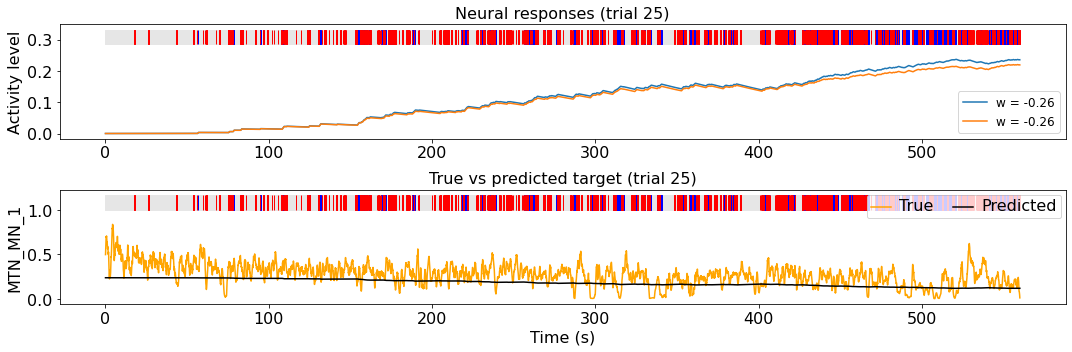

In [7]:
print(f'\nMean test R2 across all splits: {np.mean([rslt.r2_test[TARG] for rslt in rslts]):.3f}')
print('Mean test R2 within splits: ', [(split, float(f'{r2:.3f}')) for split, r2 in enumerate(r2_test_mns[:nsplit_return])])

plot_xpl(rslts, isplit=0, itr_test=1, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);

# Two slow-integrating pulse neurons with different tau_a

In [8]:
tau_rs = [120., 120.]
tau_as = [1., 2.]
x_ss = [0., 0.]
x_ps = [1., 1.]

nsplit_return = 5
rslts, r2_train_mns, r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return=range(nsplit_return))

R.......................................................................................
F................................


Mean test R2 across all splits: 0.085
Mean test R2 within splits:  [(0, 0.081), (1, 0.048), (2, 0.083), (3, 0.109), (4, 0.132)]
Neuron 1: TAU_R=120.00, TAU_A=1.000, X_S=0.00, X_P=1.00 (W = 3.14) 
Neuron 2: TAU_R=120.00, TAU_A=2.000, X_S=0.00, X_P=1.00 (W = -3.51) 


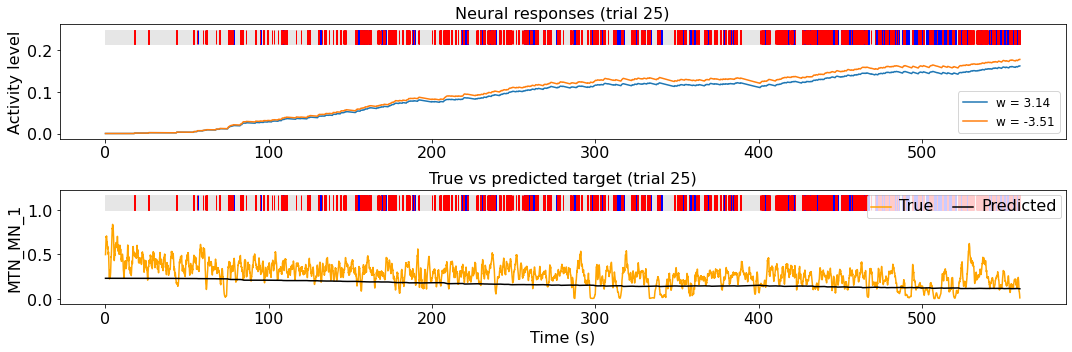

In [9]:
print(f'\nMean test R2 across all splits: {np.mean([rslt.r2_test[TARG] for rslt in rslts]):.3f}')
print('Mean test R2 within splits: ', [(split, float(f'{r2:.3f}')) for split, r2 in enumerate(r2_test_mns[:nsplit_return])])

plot_xpl(rslts, isplit=0, itr_test=1, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);

# One slow-integrating, fast-adapting pulse neuron

In [10]:
tau_rs = [120.]
tau_as = [1.]
x_ss = [0.]
x_ps = [1.]

nsplit_return = 5
rslts, r2_train_mns, r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return=range(nsplit_return))

R.......................................................................................
F................................


Mean test R2 across all splits: 0.051
Mean test R2 within splits:  [(0, 0.062), (1, 0.012), (2, 0.071), (3, 0.063), (4, 0.083)]
Neuron 1: TAU_R=120.00, TAU_A=1.000, X_S=0.00, X_P=1.00 (W = -0.70) 


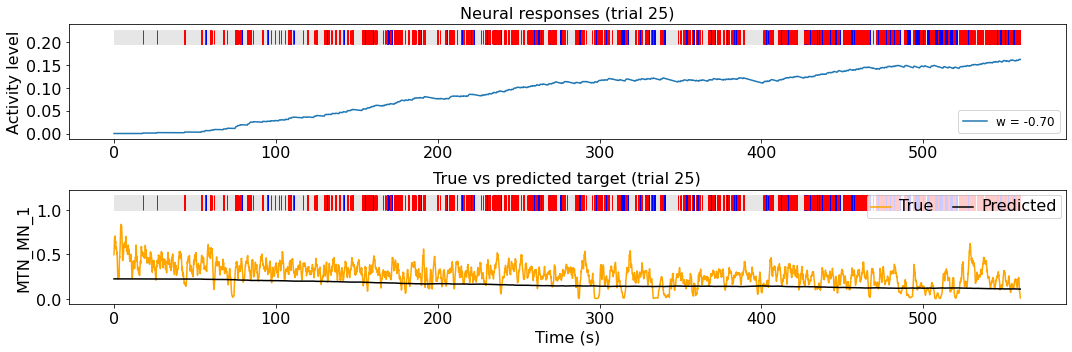

In [11]:
print(f'\nMean test R2 across all splits: {np.mean([rslt.r2_test[TARG] for rslt in rslts]):.3f}')
print('Mean test R2 within splits: ', [(split, float(f'{r2:.3f}')) for split, r2 in enumerate(r2_test_mns[:nsplit_return])])

plot_xpl(rslts, isplit=0, itr_test=1, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);

# One slow-integrating, very-fast-adapting pulse neuron

In [12]:
tau_rs = [120.]
tau_as = [.1]
x_ss = [0.]
x_ps = [1.]

nsplit_return = 5
rslts, r2_train_mns, r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return=range(nsplit_return))

R.......................................................................................
F................................


Mean test R2 across all splits: 0.028
Mean test R2 within splits:  [(0, 0.044), (1, -0.007), (2, 0.063), (3, 0.031), (4, 0.052)]
Neuron 1: TAU_R=120.00, TAU_A=0.100, X_S=0.00, X_P=1.00 (W = -1.84) 


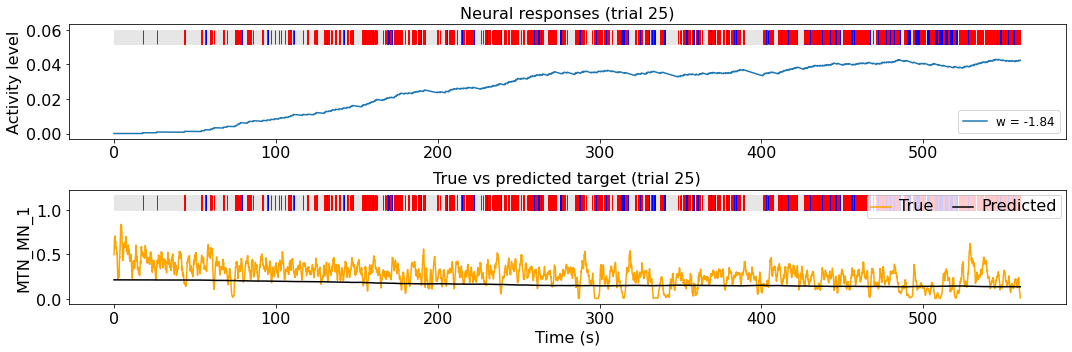

In [13]:
print(f'\nMean test R2 across all splits: {np.mean([rslt.r2_test[TARG] for rslt in rslts]):.3f}')
print('Mean test R2 within splits: ', [(split, float(f'{r2:.3f}')) for split, r2 in enumerate(r2_test_mns[:nsplit_return])])

plot_xpl(rslts, isplit=0, itr_test=1, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);

# Small collection of slow-integrating, fast adapting pulse neurons

In [8]:
tau_rs = 5*[120.]
tau_as = [.1, .5, 2, 5, 15]
x_ss = 5*[0.]
x_ps = 5*[1.]

nsplit_return = 5
rslts, r2_train_mns, r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return=range(nsplit_return))

R.......................................................................................
F................................


Mean test R2 across all splits: 0.149
Mean test R2 within splits:  [(0, 0.095), (1, 0.128), (2, 0.084), (3, 0.204), (4, 0.226)]
Neuron 1: TAU_R=120.00, TAU_A=0.100, X_S=0.00, X_P=1.00 (W = 2.48) 
Neuron 2: TAU_R=120.00, TAU_A=0.500, X_S=0.00, X_P=1.00 (W = 4.39) 
Neuron 3: TAU_R=120.00, TAU_A=2.000, X_S=0.00, X_P=1.00 (W = -0.37) 
Neuron 4: TAU_R=120.00, TAU_A=5.000, X_S=0.00, X_P=1.00 (W = -2.08) 
Neuron 5: TAU_R=120.00, TAU_A=15.000, X_S=0.00, X_P=1.00 (W = -1.95) 
Neuron 1: TAU_R=120.00, TAU_A=0.100, X_S=0.00, X_P=1.00 (W = 2.48) 
Neuron 2: TAU_R=120.00, TAU_A=0.500, X_S=0.00, X_P=1.00 (W = 4.39) 
Neuron 3: TAU_R=120.00, TAU_A=2.000, X_S=0.00, X_P=1.00 (W = -0.37) 
Neuron 4: TAU_R=120.00, TAU_A=5.000, X_S=0.00, X_P=1.00 (W = -2.08) 
Neuron 5: TAU_R=120.00, TAU_A=15.000, X_S=0.00, X_P=1.00 (W = -1.95) 


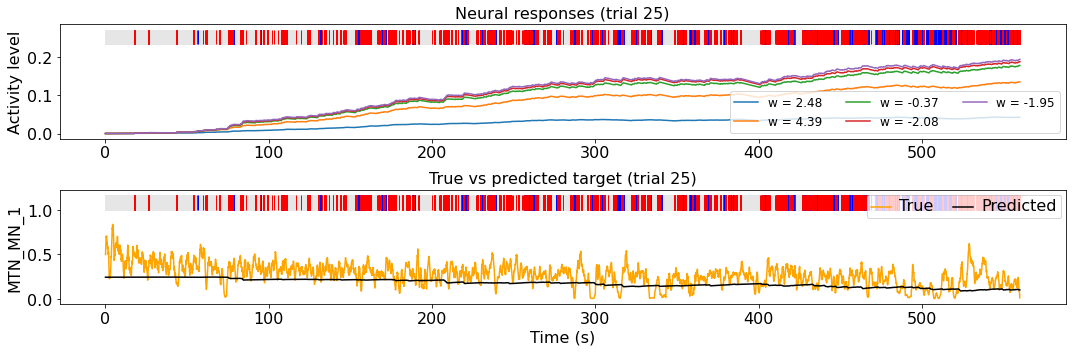

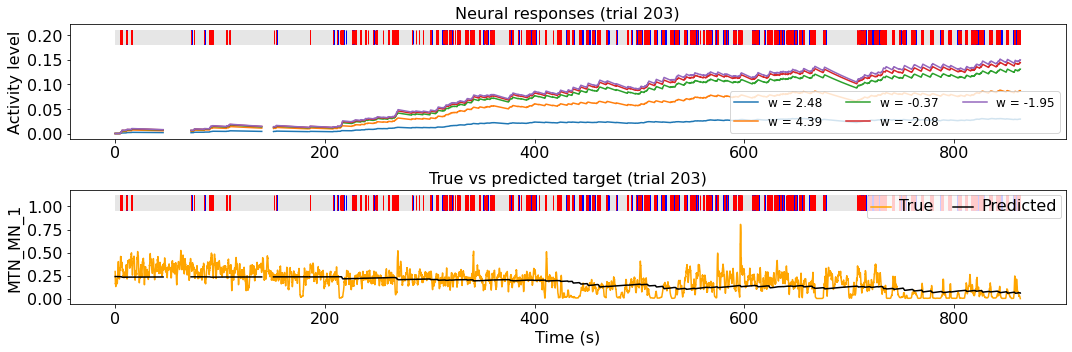

In [9]:
print(f'\nMean test R2 across all splits: {np.mean([rslt.r2_test[TARG] for rslt in rslts]):.3f}')
print('Mean test R2 within splits: ', [(split, float(f'{r2:.3f}')) for split, r2 in enumerate(r2_test_mns[:nsplit_return])])

plot_xpl(rslts, isplit=0, itr_test=1, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);
plot_xpl(rslts, isplit=4, itr_test=16, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);

# Small collection of fast-integrating, fast adapting pulse neurons

In [16]:
tau_rs = 8*[10.]
tau_as = [.1, .5, 1, 2, 3, 5, 10, 20]
x_ss = 8*[0.]
x_ps = 8*[1.]

nsplit_return = 5
rslts, r2_train_mns, r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return=range(nsplit_return))

R.......................................................................................
F................................


Mean test R2 across all splits: 0.052
Mean test R2 within splits:  [(0, 0.052), (1, 0.021), (2, 0.023), (3, 0.089), (4, 0.081)]
Neuron 1: TAU_R=10.00, TAU_A=0.100, X_S=0.00, X_P=1.00 (W = 2.04) 
Neuron 2: TAU_R=10.00, TAU_A=0.500, X_S=0.00, X_P=1.00 (W = 1.54) 
Neuron 3: TAU_R=10.00, TAU_A=1.000, X_S=0.00, X_P=1.00 (W = -0.08) 
Neuron 4: TAU_R=10.00, TAU_A=2.000, X_S=0.00, X_P=1.00 (W = -1.16) 
Neuron 5: TAU_R=10.00, TAU_A=3.000, X_S=0.00, X_P=1.00 (W = -1.38) 
Neuron 6: TAU_R=10.00, TAU_A=5.000, X_S=0.00, X_P=1.00 (W = -1.17) 
Neuron 7: TAU_R=10.00, TAU_A=10.000, X_S=0.00, X_P=1.00 (W = -0.12) 
Neuron 8: TAU_R=10.00, TAU_A=20.000, X_S=0.00, X_P=1.00 (W = 1.94) 


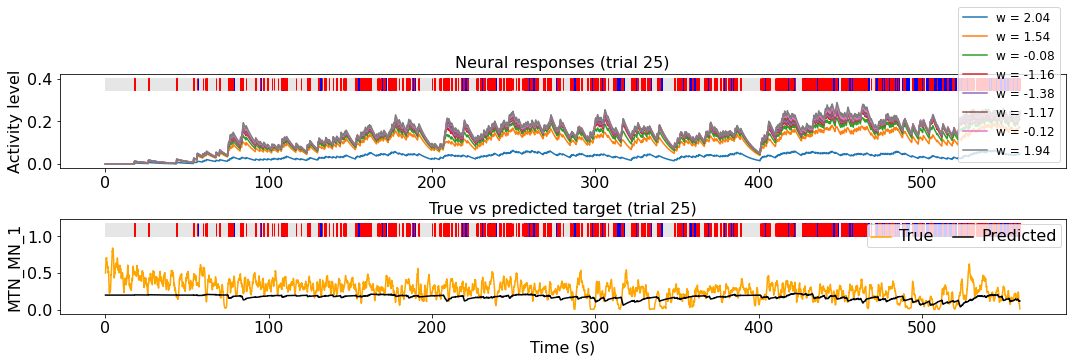

In [17]:
print(f'\nMean test R2 across all splits: {np.mean([rslt.r2_test[TARG] for rslt in rslts]):.3f}')
print('Mean test R2 within splits: ', [(split, float(f'{r2:.3f}')) for split, r2 in enumerate(r2_test_mns[:nsplit_return])])

plot_xpl(rslts, isplit=0, itr_test=1, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);

# Small collection of fast-integrating, fast adapting pulse neurons and one slow sine neuron

In [18]:
tau_rs = [120] + 8*[10.]
tau_as = [30] + [.1, .5, 1, 2, 3, 5, 10, 20]
x_ss = [1.] + 8*[0.]
x_ps = [0.] + 8*[1.]

nsplit_return = 5
rslts, r2_train_mns, r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps, splits_return=range(nsplit_return))

R.......................................................................................
F................................


Mean test R2 across all splits: 0.185
Mean test R2 within splits:  [(0, 0.232), (1, 0.219), (2, 0.175), (3, 0.117), (4, 0.246)]
Neuron 1: TAU_R=120.00, TAU_A=30.000, X_S=1.00, X_P=0.00 (W = -0.91) 
Neuron 2: TAU_R=10.00, TAU_A=0.100, X_S=0.00, X_P=1.00 (W = 1.18) 
Neuron 3: TAU_R=10.00, TAU_A=0.500, X_S=0.00, X_P=1.00 (W = 1.57) 
Neuron 4: TAU_R=10.00, TAU_A=1.000, X_S=0.00, X_P=1.00 (W = 0.84) 
Neuron 5: TAU_R=10.00, TAU_A=2.000, X_S=0.00, X_P=1.00 (W = -0.03) 
Neuron 6: TAU_R=10.00, TAU_A=3.000, X_S=0.00, X_P=1.00 (W = -0.31) 
Neuron 7: TAU_R=10.00, TAU_A=5.000, X_S=0.00, X_P=1.00 (W = -0.33) 
Neuron 8: TAU_R=10.00, TAU_A=10.000, X_S=0.00, X_P=1.00 (W = -0.21) 
Neuron 9: TAU_R=10.00, TAU_A=20.000, X_S=0.00, X_P=1.00 (W = -0.50) 


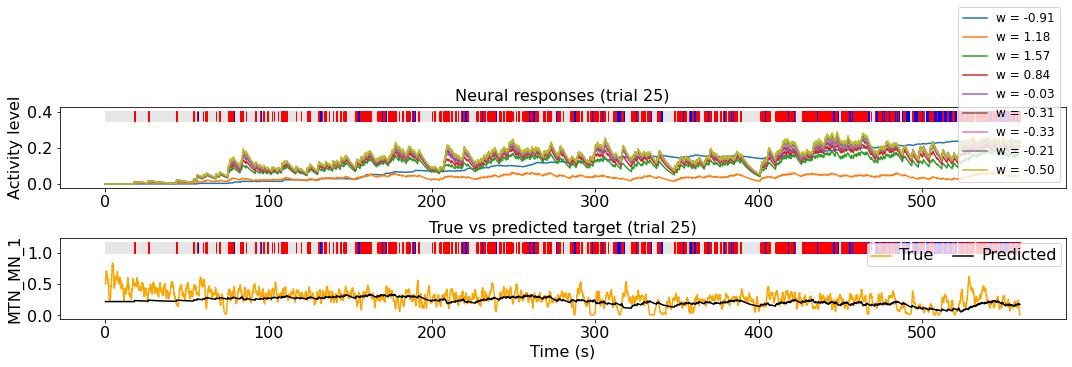

In [19]:
print(f'\nMean test R2 across all splits: {np.mean([rslt.r2_test[TARG] for rslt in rslts]):.3f}')
print('Mean test R2 within splits: ', [(split, float(f'{r2:.3f}')) for split, r2 in enumerate(r2_test_mns[:nsplit_return])])

plot_xpl(rslts, isplit=0, itr_test=1, targ=TARG, tau_rs=tau_rs, tau_as=tau_as, x_ss=x_ss, x_ps=x_ps);